<a href="https://colab.research.google.com/github/Tomawock/MLDM_COVID-19/blob/master/gradient/covid_dividiamo_modelli_gbr_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID UNIBS 2020 




## CREAZIONE DI MODELLI basati su Ensemble (Gradient Boosting)

Questo notebook ha lo scopo di addestrare alcuni **modelli** di predizione per il nostro dataset basati sulla tecnica di Ensemble **Gradient Boosting**. Utilizzeremo, come di consueto, la procedura automatizzata tramite **grid search**.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import r2_score, mean_squared_error, max_error
from sklearn.ensemble import GradientBoostingRegressor

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)
import pandas as pd
import os
os.chdir("/content/drive/Shared drives/MLDM progetto/Datasets/dataset_finali")

import warnings
warnings.filterwarnings('ignore')

Drive not mounted, so nothing to flush and unmount.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### MODELLO: preparazione dei datasets

**Carichiamo** il dataset ed impostiamo il **random state**. Trasformiamo l'attributo nominale in numerico.

**Dividiamo** il dataset in:
* **training** set
* **testing** set

Utilizziamo sempre l'**70%** dei records per il training set ed il restante per il testing.

In [20]:
df = pd.read_csv("/content/drive/Shared drives/MLDM progetto/Datasets/dataset_finali/dataset_finale_medie_ponderate_rnd1.csv", parse_dates=["Data"], infer_datetime_format=True)

#rnd_state = 432145 MOLTO MOLTO BUONO 777 22 42 6654
rnd_state = 77777
predictor_columns = [
                     'pass_Ammoniaca', 
                     'pass_Benzene',
       'pass_Biossido di Azoto', 
       'pass_Biossido di Zolfo',
       'pass_Monossido di Azoto', 
       'pass_Monossido di Carbonio',
       'pass_Ossidi di Azoto', 
       'pass_Ozono', 
       'pass_PM10 (SM2005)',
       'pass_Particelle sospese PM2.5',
       'pass_Radiazione Globale', 
       'pass_Temperatura',
       'pass_deceduti',
       'pass_nuovi_positivi',
       'pass_ricoverati_con_sintomi', 
       'pass_tamponi']

FileNotFoundError: ignored

**Prepariamo** il **training** set ed il **test** set.

In [5]:
train = df.sample(frac=0.7, random_state=rnd_state)
test = df.drop(train.index)

Preparazione dei **test e training set** per quanto concerne la previsione fra i prossimi due giorni

In [6]:
train_X_2 = train[predictor_columns]
train_y_2 = train["fut1_nuovi_positivi"]
#ricoverati con sintomi, terapia intensiva, deceduti, nuovi ospedalizzati, dimessi
test_X_2 = test[predictor_columns]
test_y_2 = test["fut1_nuovi_positivi"]

Preparazione dei **test e training set** per quanto concerne la previsione fra i prossimi quattro giorni

In [7]:
train_X_4 = train[predictor_columns]
train_y_4 = train["fut2_nuovi_positivi"]

test_X_4 = test[predictor_columns]
test_y_4 = test["fut2_nuovi_positivi"]

### MODELLO: training ###

Creiamo il **regressore** basato su gradient boosting.

In [8]:
gb_regressor = GradientBoostingRegressor(random_state=rnd_state)

Definiamo la **Pipeline**, come abbiamo fatto per le ANN:
* imputer
* addestramento del modello

In [9]:
pipeline = Pipeline([("imp", SimpleImputer(missing_values=np.nan, strategy="mean")), 
                     ("gbr", gb_regressor)])

Prepariamo gli **iper-parametri** per la grid search.

In [10]:
loss_list = ["ls", "lad"]
n_estimators_list = [100]
criterion_list = ["mse", "friedman_mse"]
min_samples_split_list = [2, 3]
min_samples_leaf_list = [1, 2]
max_depth_list = [3, 5]
max_features_list = ["sqrt", "auto"]

param_grid = {"gbr__loss": loss_list,
              "gbr__n_estimators": n_estimators_list,
              "gbr__criterion": criterion_list,
              "gbr__min_samples_split": min_samples_split_list,
              "gbr__min_samples_leaf": min_samples_leaf_list,
              "gbr__max_depth": max_depth_list,
              "gbr__max_features": max_features_list}

**Addestriamo** il regressore mediante **grid search** e **k-fold** cross validation. Anche questa volta, utilizziamo k non superiore a 4 in modo da avere degli insiemi statisticamente significativi.

In [11]:
kfold_splits = 4
grid_regressor_2 = GridSearchCV(estimator=pipeline,  
                              n_jobs=-1, 
                              verbose=1,
                              return_train_score=True,
                            cv=KFold(n_splits=kfold_splits, shuffle=True, random_state=rnd_state),
                              param_grid=param_grid)

grid_regressor_2.fit(train_X_2, train_y_2)

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 253 out of 256 | elapsed:   23.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   23.8s finished


GridSearchCV(cv=KFold(n_splits=4, random_state=1257896432, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('gbr',
                                        GradientBoostingRegressor(alpha=0.9,
                                                                  ccp_alpha=0.0,
                                                                  criterion='friedman_mse',
                                                                  init=None,
       

In [12]:
kfold_splits = 4
grid_regressor_4 = GridSearchCV(estimator=pipeline,  
                              n_jobs=-1, 
                              verbose=1,
                              return_train_score=True,
                            cv=KFold(n_splits=kfold_splits, shuffle=True, random_state=rnd_state),
                              param_grid=param_grid)

grid_regressor_4.fit(train_X_4, train_y_4)

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   21.8s finished


GridSearchCV(cv=KFold(n_splits=4, random_state=1257896432, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('gbr',
                                        GradientBoostingRegressor(alpha=0.9,
                                                                  ccp_alpha=0.0,
                                                                  criterion='friedman_mse',
                                                                  init=None,
       

### MODELLO: testing ###

Processiamo i dati di test allo stesso modo del training e procediamo alla fase di testing del **miglior regressore**, addestrato mediante grid search.

In [13]:
best_regressor_2 = grid_regressor_2.best_estimator_["gbr"]

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X_2)
test_X_imp = imputer.transform(test_X_2)

predicted_2 = best_regressor_2.predict(test_X_imp)

In [14]:
best_regressor_4 = grid_regressor_4.best_estimator_["gbr"]

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X_4)
test_X_imp = imputer.transform(test_X_4)

predicted_4 = best_regressor_4.predict(test_X_imp)

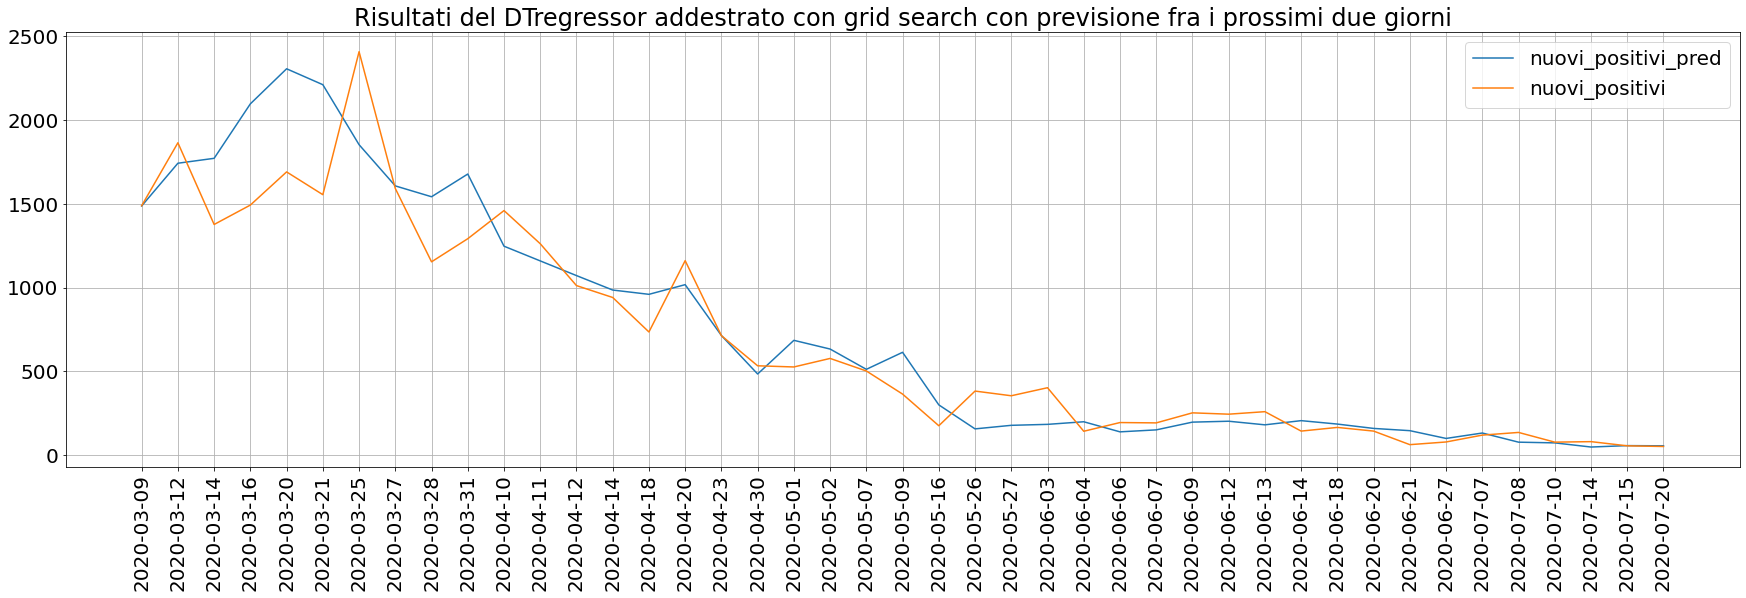

In [15]:
x_triks=df.loc[list(test_X_2.index),['Data']]
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (30, 8)
plt.plot(predicted_2, label="nuovi_positivi_pred")
plt.plot(test_y_2.values, label="nuovi_positivi")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks['Data'].dt.date), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati del DTregressor addestrato con grid search con previsione fra i prossimi due giorni")
plt.show()

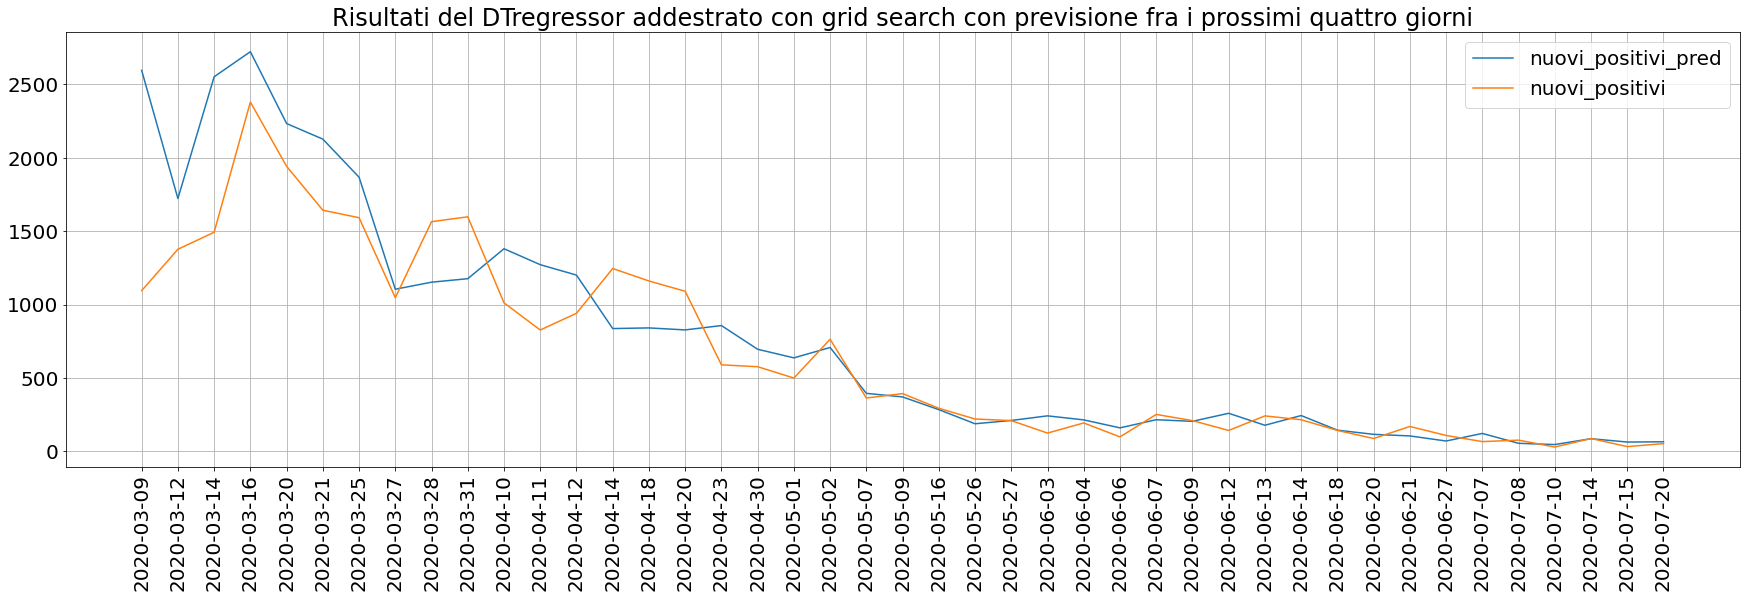

In [16]:
x_triks=df.loc[list(test_X_4.index),['Data']]
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (30, 8)
plt.plot(predicted_4, label="nuovi_positivi_pred")
plt.plot(test_y_4.values, label="nuovi_positivi")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks['Data'].dt.date), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati del DTregressor addestrato con grid search con previsione fra i prossimi quattro giorni")
plt.show()

### MODELLO: valutazione ed osservazioni ###

Vediamo le **caratteristiche** del miglior Gradient Boosting regressor trovato.

In [ ]:
best_regressor_2

In [ ]:
best_regressor_4

Si tratta di un regressore di insieme che contiene **100** alberi di decisione, che sfrutta il **subsampling delle features**.

Calcoliamo alcune **misure di performance** per il regressore di insieme. Abbiamo scelto quelle a parer nostro più significative:
* **R2**: coefficiente di determinazione
* **RMSE**: root mean squared error
* **MAX Error**: errore massimo

Visualizziamo i coefficienti per quanto riguarda la previsione fra **due giorni**

In [17]:
print(f"R2: \t\t{r2_score(test_y_2, predicted_2):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y_2, predicted_2, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y_2, predicted_2)}")

R2: 		0.857
RMSE: 		2.34e+02
MAX ERR: 	656.9005356250691


Visualizziamo i coefficienti per quanto riguarda la previsione fra **quattro giorni**

In [18]:
print(f"R2: \t\t{r2_score(test_y_4, predicted_4):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y_4, predicted_4, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y_4, predicted_4)}")

R2: 		0.683
RMSE: 		3.5e+02
MAX ERR: 	1500.5888317684999


**Osserviamo** che le performance del miglior regressore addestrato sono molto **buone**.

**R2** è **0.918**, ampiamente superiore a 0.5 e molto vicino ad 1 (R2 massimo). Il modello spiega gran parte della varianza dei dati.

**RMSE** è **52.1**, pertanto il modello in media sbaglia il conteggio dei nuovi positivi di 52 unità.

**MAX ERR** è **182.38**. Dal grafico si nota come in un preciso giorno il predittore sbagli considerevolmente. Questo errore abbastanza pronunciato va ad influenzare negativamente l'RMSE.

### MODELLO: feature importance

Anche per il regressore basato su gradient boosting, abbiamo a disposizione la **feature importance**.

Visualizziamo la feature importance per quanto riguarda la previsione fra **due giorni**

In [ ]:
feature_importance = dict(zip(predictor_columns, best_regressor_2.feature_importances_))
for w in sorted(feature_importance, key=feature_importance.get, reverse=True):
    print(w, feature_importance[w])

Visualizziamo la feature importance per quanto riguarda la previsione fra **quattro giorni**

In [ ]:
feature_importance = dict(zip(predictor_columns, best_regressor_4.feature_importances_))
for w in sorted(feature_importance, key=feature_importance.get, reverse=True):
    print(w, feature_importance[w])